First, run
download_wikipedia.ipynb 
to get the file
wikipedia_three_sentences.csv

Then, we do our processing here

random note: #could upgrade to use a 4090 or A6000

In [28]:
stopping_index=8
num_editing_heads = 768*2 #more seems to be better for this #per sid's suggestion: can add more heads in every layer. This is probably a really great suggestion
editor_channel_width = 768 * 2
max_grad_clip = 4.0
chop_layer = 8
lr = 4e-4
edit_dampening_factor=1e-4

notes from Sid: SAE vs principal components
-you could try to work on the SAE's???
-get discrete targets
[I wouldn't be surprised at all if this helped a lot]


-Next deliverables:

In [3]:
#batch['tokenized_first_sentence'][30].size(), batch['tokenized_next_50_tokens'][30].size()


In [4]:
# Trying out the editor hypernetwork on the dune dataset
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="hypernetworks",
    config={"targetmodel": "gpt2", "editormodel": "gpt2"},
)
# Copy this below where needed!
# run.log_model(path="<path-to-model>", name="<name>")

# wandb.log({"acc": acc, "loss": loss})

# wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michaelbsklar (michaelsklar). Use `wandb login --relogin` to force relogin


In [5]:
# CUDA_LAUNCH_BLOCKING=1
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Set torch default device
import torch
torch.set_default_device("cuda")

In [6]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2Model
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
import torch
from torch import compile
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import transformers
from tqdm import tqdm
import pandas as pd
import yaml
import contextlib
import os
import time

In [7]:
def add_cross_attention_to_layer(block, config):
    block.crossattention = GPT2Attention(config, is_cross_attention=True)
    block.ln_cross_attn = nn.LayerNorm(
        normalized_shape=768, eps=config.layer_norm_epsilon
    )
    original_query_weights = block.attn.c_attn.weight[:, :768]
    original_keys_values = block.attn.c_attn.weight[:, 768:]
    original_query_bias = block.attn.c_attn.bias[:768]
    original_keys_values_bias = block.attn.c_attn.bias[768:]
    with torch.no_grad():
        # Initialize the new layer with these parameters
        block.crossattention.q_attn.weight = nn.Parameter(original_query_weights)
        block.crossattention.q_attn.bias = nn.Parameter(original_query_bias)
        block.crossattention.c_attn.weight = nn.Parameter(original_keys_values)
        block.crossattention.c_attn.bias = nn.Parameter(original_keys_values_bias)
    return

Now, we stick on the "reverse attention" module at the end!
This is a customized attention head that reads from the editor model, and writes to the target model's activations

In [8]:
class Editor_Attention(nn.Module):
    def __init__(self, config):
        super().__init__()

        #Controls whether the head will do a global softmax in all positions & layers
        #If True, the attn is global and will sum to 1
        #If False, the attn is a logistic fxn independently for every layer & token
        #I suspect we will also want to penalize the intervention norm
        self.num_editing_heads = config.num_editing_heads #should default to 1, but we're going to test adding more
        self.edit_channel_width = config.edit_channel_width
        if self.edit_channel_width % self.num_editing_heads != 0:
            print("Error: config hidden size is not divisible by num_editing_heads")
        self.head_dim = self.edit_channel_width // self.num_editing_heads
        self.embed_dim = config.hidden_size

        max_positions = config.max_position_embeddings #does this do anything? can try killing this later
        self.register_buffer(
            "bias",
            torch.tril(
                torch.ones((max_positions, max_positions), dtype=torch.bool)
            ).view(1, 1, max_positions, max_positions),
            persistent=False,
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4), persistent=False)

        # We compute Q and K as a single nn.linear; but will later break apart into subcomponents

        ## Before modification to a variable channel-width
        # self.q_attn = nn.Linear(self.embed_dim, self.embed_dim)
        # self.k_attn = nn.Linear(self.embed_dim, self.embed_dim)
        # self.v_attn = nn.Linear(self.embed_dim, self.embed_dim)
        # self.out_proj = nn.Linear(self.embed_dim, self.embed_dim) 
        
        
        self.q_attn = nn.Linear(self.embed_dim, self.edit_channel_width)
        self.k_attn = nn.Linear(self.embed_dim, self.edit_channel_width)
        self.v_attn = nn.Linear(self.embed_dim, self.edit_channel_width)
        self.out_proj = nn.Linear(self.edit_channel_width, self.embed_dim) 

    def _split_heads(self, x):
        """Split the last dimension into (num_heads, head_dim)."""
        new_shape = x.size()[:-1] + (self.num_editing_heads, self.head_dim)
        return x.view(*new_shape)
    
    def _new_reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # Assume that we are doing softmax attention

        # Project and split the query, key, value tensors
        split_query = self._split_heads(query)  
        split_key = self._split_heads(key)
        split_value = self._split_heads(value)
        
        #Double-application (is this actually good/better for some reason?)
        #self._split_heads(self.q_attn(query))
        #self._split_heads(self.k_attn(key))
        #self._split_heads(self.v_attn(value))

        if split_query.dim() != 4:
            print("Error: Expected query to be 4D tensor, but got something else!")
        if split_key.dim() != 3:
            print("Error: Expected key to be 3D tensor, but got something else!")
        if split_value.dim() != 3:
            print("Error: Expected value to be 3D tensor, but got something else!")

        # Query should be shaped as (batch_index, sequence_index, head_index, head_dim)
        # Key and value should be shaped as (batch_index, head_index, head_dim)
    
        KQ_weights = torch.matmul(split_query.permute(0,2,1,3),split_key.unsqueeze(-1)).squeeze(-1)

        # Then we take the softmax within the positional divisions
        softmaxed_weights = nn.functional.softmax(KQ_weights, dim=-1)
        
        # Adjusting value selection for head dimension
        attn_output = torch.matmul(softmaxed_weights.unsqueeze(-1), split_value.unsqueeze(-2))

        #combine heads: change 50, 8, 104, 96 to 50, 104, 768
        #first, permute
        attn_output = attn_output.permute(0,2,1,3)
        #combin heads x head_dims
        attn_output = attn_output.reshape(-1,attn_output.size(1),attn_output.size(2)*attn_output.size(3))
        # now project back
        projected_output = self.out_proj(attn_output)
    
        return projected_output, softmaxed_weights

    def _reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):

        if key.dim() == 4:
            K_reduced = key[
                :, :, -1, :
            ]  # R# Check: that the second dimension of K is only a single element when we have batching
            KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
            logistic_weights = torch.atan(KQ_weights)
            attn_output = torch.bmm(
                logistic_weights.transpose(1, 2), value[:, :, -1, :] #we take the editor output only over the final token position
            )

        if key.dim() == 3:
            QK_weights = torch.matmul(query, key.transpose(-1, -2))
            logistic_weights = torch.atan(QK_weights)
            attn_output = torch.matmul(logistic_weights, value)

        return attn_output, logistic_weights


    def forward(
        self,
        editor_hidden_states,
        target_hidden_states,
        attention_mask=None,
        output_attentions=False,
    ):

        # Here, the query is the target hidden encoder, the key is the editor, and the value is the editor
        query = self.q_attn(target_hidden_states)
        if editor_hidden_states.dim() == 3:
            key = self.k_attn(
                # I don't quite understand why sometimes editor_hidden_states is 4 dimensional, sometimes 3
                #seems like it's sometimes 20, 1, 4, 768 and sometimes 20, 4, 768. what gives?
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position

        if editor_hidden_states.dim() == 4:
            key = self.k_attn(
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position

        attn_output, attn_weights = self._new_reverse_attn(query, key, value)

        if output_attentions:
            return attn_output, attn_weights
        else:
            return attn_output

In [9]:
import types
from typing import Optional, Tuple, Union


def new_forward(
    self,
    input_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    token_type_ids: Optional[torch.LongTensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.Tensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    # labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple]:
    r"""
    labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
        Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
        `labels = input_ids` Indices are selected in `[-100, 0, ..., config.vocab_size]` All labels set to `-100`
        are ignored (masked), the loss is only computed for labels in `[0, ..., config.vocab_size]`
    """

    transformer_outputs = self.transformer(
        input_ids,
        past_key_values=past_key_values,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_attention_mask,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )
    hidden_states = transformer_outputs[0]

    # Set device for model parallelism
    if self.model_parallel:
        torch.cuda.set_device(self.transformer.first_device)
        hidden_states = hidden_states.to(self.lm_head.weight.device)

    # lm_logits = self.lm_head(hidden_states)
    reverse_attention_output = self.lm_head(
        hidden_states, encoder_hidden_states, output_attentions=output_attentions
    )

    return reverse_attention_output

In [10]:
def replace_linear_final_layer_with_bespoke_reverse_attention(model):
    model.lm_head = Editor_Attention(config=model.config)
    model.forward = new_forward.__get__(model, GPT2LMHeadModel)
    return

In [11]:
@contextlib.contextmanager
def add_fwd_hooks(module_hooks):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for mod, hk in module_hooks:
            handles.append(mod.register_forward_hook(hk))
        yield
    finally:
        for h in handles:
            h.remove()

In [12]:
def assign_layer_indices(model):
    """
    Assigns a custom attribute 'layer_index' to each transformer layer in the GPT-2 model.
    This function iterates over the transformer blocks and assigns an index to each.
    """
    model.transformer.wte.layer_index = 0
    for i, layer in enumerate(model.transformer.h):
        layer.layer_index = i + 1


# Usage:
# assign_layer_indices(target_model)

In [13]:
def concat_and_pad(A, B):
    batch_size, n_tokens_A = A.size()
    n_tokens_B = B.size(1)

    #Find the lengths in A and B
    lengths_A = torch.sum(A != 50256, dim=1)
    lengths_B = torch.sum(B != 50256, dim=1)

    #iniitalize empty tensor
    result = torch.full((batch_size, max(lengths_A + lengths_B),), 50256)

    #Concatenate A[i] and B[i] a
    for i in range(batch_size):
        result[i, : lengths_A[i]] = A[i, : lengths_A[i]]
        result[i, lengths_A[i] : lengths_A[i] + lengths_B[i]] = B[i, : lengths_B[i]]

    # # Concatenate A and B along dimension 1
    # concatenated = torch.cat((A, B), dim=1)
    
    # # Find the number of non-zero elements in each row of concatenated tensor
    # lengths = torch.sum(concatenated != 50256, dim=1)
    
    # # Create a mask to identify the non-zero elements in concatenated tensor
    # mask = torch.arange(n_tokens_A + n_tokens_B).expand(batch_size, n_tokens_A + n_tokens_B) < lengths.unsqueeze(1)
    
    # # Create a new tensor with the same shape as concatenated tensor
    # result = torch.full_like(concatenated, 50256)
    
    # # Move the non-zero elements to the left and zero elements to the right
    # result[mask] = concatenated[mask]

    return result

In [14]:
def check_nan_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f"NaN values found in gradient of parameter: {name}")
            return True
    return False

In [15]:
#@torch.compile #Apparently this fails when used inside jupyter notebooks but is fine if i make dedicated scripts
class EditorHypernetwork(nn.Module):
    # Separating the editor config file, from its base model's configurations
    def __init__(self,         
        num_editing_heads=32,
        edit_channel_width=768, #controls dimensionality given to attention heads in the last layer of the editor
        use_layerwise_embeddings=True,
        chop_editor_at_layer = None,
        edit_dampening_factor=.001,#tuning parameter to help the edits not be initialized too large
        kill_token_zero = False, #multiplies edits to token pos zero by zero
        ):

        super().__init__()

        # Construct Editor Model
        # Load the configuration from the YAML file
        # with open(editor_yaml_file_path, 'r') as file:
        #     self.config = yaml.safe_load(file)
        self.editor_model = GPT2LMHeadModel.from_pretrained(
            "gpt2"
        ).cuda().eval()  # have recently added .cuda() so it uses the gpu

        # Add cross-attention to each layer
        self.editor_model.config.add_cross_attention = True
        self.editor_model.config.num_editing_heads = num_editing_heads
        self.editor_model.config.chop_layer = chop_editor_at_layer
        self.editor_model.config.kill_token_zero = kill_token_zero
        self.editor_model.config.edit_channel_width = edit_channel_width
        
        if chop_editor_at_layer is None:
            chop_editor_at_layer = 12

        for i in range(chop_editor_at_layer):
            add_cross_attention_to_layer(
                self.editor_model.transformer.h[i], self.editor_model.config
            )
        
        #Delete extra layers beyond the chop_layer
        self.editor_model.transformer.h = self.editor_model.transformer.h[:chop_editor_at_layer]

        # Replace the final linear layer with special reverse attention output
        self.editor_model.lm_head = Editor_Attention(config=self.editor_model.config)
        self.editor_model.forward = new_forward.__get__(
            self.editor_model, GPT2LMHeadModel
        )
        self.editor_model.cuda()

        # Construct Target Model
        self.target_model = transformers.AutoModelForCausalLM.from_pretrained(
            "gpt2"
        ).cuda().eval()
        for param in self.target_model.parameters():
            param.requires_grad = False
        assign_layer_indices(self.target_model)

        self.target_model.cuda()

        # Add module for layerwise embeddings
        if use_layerwise_embeddings:
            self.use_layerwise_embeddings = True
            self.layerwise_embeddings = torch.randn(13, 768, requires_grad=True).cuda()
        else:
            self.use_layerwise_embeddings = False
            self.layerwise_embeddings = 0

        self.edit_dampening_factor = edit_dampening_factor

        self.residual_cache = None
        self.opt = None
        self.lossfn = None
        self.lam = None
        self.penalty_loss= None
        self.training_loss = None

    # Gets the hidden states from the target model, if necessary
    def run_target_model_for_encoded_hidden_states(self, target_ids):
        with torch.no_grad():
            outputs = self.target_model(target_ids, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            return hidden_states

    def forward(
        self,
        editor_input_ids,
        target_input_ids,
        target_hidden_states=None,
        output_target_hidden_states=False,
        output_edited_hidden_states=False,
        output_edit_vectors=False,
        output_editor_attention=False,
        stop_editing_index=None,
        batch_edit_vectors=None,
    ):

        # Run target model for encoded hidden states
        if target_hidden_states is None:
            target_hidden_states = torch.stack(
                self.run_target_model_for_encoded_hidden_states(
                    target_input_ids.to("cuda")
                ), #seems to break while we are passing thru batch_size=1; the last (12th =) has different dimensions
                dim=2,
            )
        # dimensions of target_hidden_states:
        # batch_size, token_sequence_length, num_layers = 13, resid_width = 768

        # If we are stopping editing at stop_editing_index, then we eliminate target_hidden_states beyond that index
        if stop_editing_index is not None:
            target_hidden_states = target_hidden_states[
                :, :stop_editing_index, :, :
            ].clone()

        # Normalize along the last dimension
        normalization_factors = target_hidden_states.norm(dim=-1, keepdim=True)
        target_hidden_states = target_hidden_states / normalization_factors

        # Error catching:
        if batch_edit_vectors is not None:
            if output_edit_vectors or output_editor_attention:
                return "Error: Inputting your own batch_edit_vectors means the model does not construct the outputs you are requesting"

        # Run editor model, get edit vectors
        if batch_edit_vectors is None:
            if self.use_layerwise_embeddings:
                # Now, add in the layerwise embeddings
                embedded_hidden_states = target_hidden_states + self.layerwise_embeddings[None, None, :, :]

                collapsed_target_hidden_states = embedded_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            else:
                collapsed_target_hidden_states = target_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            
            editor_output = self.editor_model(
                editor_input_ids.to("cuda"),
                encoder_hidden_states=collapsed_target_hidden_states,
                output_attentions=output_editor_attention,
            )
            # Multiply the outputs by normalization factors
            if output_editor_attention:
                temp_edit_vectors = editor_output[0]
                # Might want to reshape this too but whatever
                batch_editor_attention = editor_output[1]
            else:
                temp_edit_vectors = editor_output
            
            #Renormalize to the scale of the target hidden states
            #and reshape to proper dimensions
            batch_edit_vectors = self.edit_dampening_factor * normalization_factors * temp_edit_vectors.reshape(
                    temp_edit_vectors.shape[0], stop_editing_index, 13, 768
                )
            
        # If we are stopping editing at stop_editing_index,
        # this pads batch_edit_vectors with 0's to the right of the edited positions
        if stop_editing_index is not None:
            batch_edit_vectors = torch.cat(
                (
                    batch_edit_vectors,
                    torch.zeros(
                        batch_edit_vectors.shape[0],
                        target_input_ids.shape[1] - stop_editing_index,
                        13,
                        768,
                    ),
                ),
                dim=1,
            )

        # Run target model with edit vectors. This adds the edit vectors to the given hidden state at the specified batch index, position, and layer
        def edit_add(module, input, output):
            layer_index = module.layer_index
            output[0][:] = output[0] + batch_edit_vectors[:, :, layer_index, :]
            if self.editor_model.config.kill_token_zero == True:
                output[0][:, 0, :] = 0

        def embedding_edit_add(module, input, output):
            output[:] = output + batch_edit_vectors[:, :, 0, :]
            if self.editor_model.config.kill_token_zero == True:
                output[:, 0, :] = 0

        # Now editing the target model
        hooks1 = [(self.target_model.transformer.wte, embedding_edit_add)]
        hooks2 = [(self.target_model.transformer.h[L], edit_add) for L in range(12)]
        hooks = hooks1 + hooks2
        with add_fwd_hooks(hooks):
            # THIS IS THE LINE WHERE THE MODEL IS CALLED (AND THE EDITOR IS CALLED AT
            # THE END OF `layer` AS A SIDE EFFECT)
            target_result = self.target_model(
                target_input_ids.to("cuda"),
                output_hidden_states=output_edited_hidden_states,
            )

        logits = target_result.logits

        output = {}
        output["logits"] = logits
        if output_target_hidden_states:
            output["target_hidden_states"] = (
                target_hidden_states * normalization_factors
            )
        if output_edited_hidden_states:
            output["edited_hidden_states"] = target_result.hidden_states
        if output_edit_vectors:
            output["edit_vectors"] = batch_edit_vectors
        if output_editor_attention:
            output["editor_attention"] = batch_editor_attention
        return output

    # Generate text using the target model, with a new edit application at every step.
    # This is a very slow way to generate text.
    # If you only want to edit first k tokens, use the forward pass instead with stop_editing_index = k
    def inspect_batch_prediction_ouptuts(self, batch):
        with torch.no_grad():
            batch_size = len(batch["tokenized_first_sentence"])
            self.editor_inputs = batch["tokenized_first_sentence"][i].unsqueeze(0)
            self.target_inputs = batch["tokenized_next_50_tokens"][i].unsqueeze(0)
            self.prediction = self.forward(
                self.editor_inputs,
                self.target_inputs,
                stop_editing_index=stop_editing_index,
                output_target_hidden_states=False,
                output_edited_hidden_states=False,
                output_edit_vectors=False,
                output_editor_attention=False,
            )
            #compute most likely tokens from the logits
            predicted_ids = [torch.argmax(pred, dim=-1) for pred in self.prediction["logits"]]
            #convert the token ids to strings
            predicted_strings = [tokenizer.decode(pred) for pred in predicted_ids]
            return predicted_strings

    def evaluate_KL_test_loss_nogradient(self,dataloader, f_data_to_soft_labels = None, stop_editing_index=8):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_samples = 0
            for batch in dataloader:
                current_batch_size = len(batch["tokenized_first_sentence"])
                self.editor_inputs = batch["tokenized_first_sentence"].squeeze(1)
                self.target_inputs = batch["tokenized_next_50_tokens"].squeeze(1)
                self.prediction = self.forward( #check the batch size
                    self.editor_inputs,
                    self.target_inputs,
                    stop_editing_index=stop_editing_index
                )
                log_prob_predictions = torch.nn.functional.log_softmax(
                    self.prediction["logits"][
                        :, stop_editing_index:, :
                    ].reshape(-1, 50257),
                    dim=1,
                )
                # Now we must compute the soft labels!
                # join the last 50 tokens to the editor inputs
                soft_labels = f_data_to_soft_labels(
                    batch["tokenized_first_sentence"],
                    batch["tokenized_next_50_tokens"],
                    num_predictions_max=50
                )
                mask = (batch["tokenized_next_50_tokens"] != 50256).reshape(-1)
                self.loss = torch.nn.functional.kl_div(log_prob_predictions[mask,:], soft_labels[mask,:], reduction = 'batchmean')
                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += self.loss.item() * current_batch_size
                total_samples += current_batch_size
            weighted_average_loss = sum_weighted_losses / total_samples
        return weighted_average_loss

    def evaluate_crossentropy_test_loss_nogradient(self,dataloader, stop_editing_index=8):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_samples = 0
            for batch in dataloader:
                #current_batch_size = len(batch["tokenized_first_sentence"])
                self.editor_inputs = batch["tokenized_first_sentence"].squeeze(1)
                self.target_inputs = batch["tokenized_next_50_tokens"].squeeze(1)
                self.prediction = self.forward( #check the batch size
                    self.editor_inputs,
                    self.target_inputs,
                    stop_editing_index=stop_editing_index
                )
                log_prob_predictions = torch.nn.functional.log_softmax(
                    self.prediction["logits"][
                        :, stop_editing_index:, :
                    ].reshape(-1, 50257),
                    dim=1,
                )

                # Create a mask to exclude padded tokens
                target_labels = self.target_inputs[:, stop_editing_index:].reshape(-1)
                mask = (target_labels != 50256)  # Assuming padded tokens are represented by 0

                # Compute the cross-entropy loss with masking
                criterion = torch.nn.CrossEntropyLoss(reduction='none')
                loss = criterion(log_prob_predictions, target_labels)
                current_mask_sum = mask.sum()
                loss = (loss * mask).sum() / current_mask_sum

                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += loss * current_mask_sum
                total_tokens += curr_mask_sum
            weighted_average_loss = sum_weighted_losses / total_tokens
        return weighted_average_loss

    def train(
        self,
        train_loader,
        test_loader=None,
        stop_editing_index=8,
        epochs=1,
        KL_divergence_loss=False,
        lam = 0, #20000
        lam_testing_penalty = 0, #100000
        f_data_to_soft_labels=None,
        checkpoint_interval=60, #save checkpoint every 60 minutes
    ):
        self.opt = optim.AdamW(self.parameters(), lr= lr, weight_decay=.01) #usually: lr = 5e-5. 1e-3 worked well!

        if KL_divergence_loss:
            self.lossfn = nn.KLDivLoss(reduction = 'batchmean')
        else:
            self.lossfn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # Create a tqdm progress bar
            with tqdm(
                total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"
            ) as pbar:
                num_datapoints_in_epoch=0
                epoch_train_loss = 0
                epoch_gradient_norm = 0
                # Train loop
                batch_index = -1 #index of first batch will be 0

                for batch in train_loader: #not sure what this does for fractional batches. meh whatev
                    batch_index += 1
                    self.batch = batch
                    current_batch_size = len(batch["tokenized_next_50_tokens"])
                    num_datapoints_in_epoch += current_batch_size
                    self.opt.zero_grad()

                    # Forward pass
                    self.prediction = self.forward(
                        batch["tokenized_first_sentence"],
                        batch["tokenized_next_50_tokens"],
                        stop_editing_index=stop_editing_index,
                        output_target_hidden_states=True,
                        output_edited_hidden_states=True,
                        output_edit_vectors=True,
                    )

                    # Compute the penalty (edit size relative to the hidden state)
                    self.lam = lam
                    edit_ratio = self.prediction['edit_vectors'].norm(dim=-1)[:,:stop_editing_index,:]/self.prediction['target_hidden_states'].norm(dim=-1)
                    self.per_datapoint_penalty_loss = self.lam * torch.sum(edit_ratio,dim=[1,2])
                    self.penalty_loss = torch.mean(self.per_datapoint_penalty_loss)
                    
                    # Compute the data loss
                    if KL_divergence_loss:
                        log_prob_predictions = torch.nn.functional.log_softmax(
                            self.prediction["logits"][:, :, :
                            ].reshape(-1, 50257),
                            dim=1,
                            )
                        # Now we must compute the soft labels! This is outsourced to the user-provided function, teacher_model
                        self.soft_labels = f_data_to_soft_labels(
                            batch["tokenized_first_sentence"],
                            batch["tokenized_next_50_tokens"],
                            num_predictions_max=50
                        )
                        #check that the mask makes sense!
                        mask = (batch["tokenized_next_50_tokens"] != 50256).reshape(-1)
                        self.prediction_loss = self.lossfn(log_prob_predictions[mask, :], self.soft_labels[mask,:])
                        #NOTE: currently I am letting the loss predict on tokens inside the editing window
                        #I didn't do this in the previous testing! Nor is it the case in crossentropy
                    
                    else: 
                        log_prob_predictions = torch.nn.functional.log_softmax(
                            self.prediction["logits"][:, stop_editing_index:, :
                            ].reshape(-1, 50257),
                            dim=1,
                            )
                        # Create a mask to exclude padded tokens
                        #NOTE: here we are disallowing prediction on the first stop_editing_index tokens. 
                        #Code is currently formatted such that this is not the case for KL
                        target_labels = batch["tokenized_next_50_tokens"][:, stop_editing_index:].reshape(-1)
                        mask = (target_labels != 50256)
                        # Compute the cross-entropy loss with masking
                        criterion = torch.nn.CrossEntropyLoss(reduction='none')
                        loss = criterion(log_prob_predictions, target_labels.long())
                        current_mask_sum = mask.sum()
                        self.prediction_loss = (loss * mask).sum() / current_mask_sum

                    

                    # Compute the total loss and backpropagate 
                    self.training_loss = self.prediction_loss + self.penalty_loss
                    self.training_loss.backward()
                    nn.utils.clip_grad_norm_(self.parameters(), max_grad_clip) #just implemented this! dunno if a cap of 1 to large, so I'm messing with reducing it

                    #Check for nan gradients 
                    # if check_nan_gradients(self):                   
                    #     break

                    #Backwards step
                    self.opt.step()

                    #metrics
                    epoch_train_loss += self.training_loss.item()*current_batch_size
                    gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                    all_gradients = torch.cat(gradients)
                    gradient_norm = torch.norm(all_gradients).item()
                    epoch_gradient_norm += gradient_norm*current_batch_size
                    wandb.log({"train_batch_total_loss": self.training_loss.item(),
                               "train_batch_prediction_loss": self.prediction_loss.item(),
                                "train_batch_penalty_loss": self.penalty_loss,
                                "train_batch_gradient_norm": gradient_norm,
                               })

                    # Update progress bar
                    pbar.update(1) #note: this was incorrectly displaying before!

                    # Check if it's time to save a checkpoint
                    current_time = time.time()
                    # first loop initialization
                    if batch_index == 0 and epoch == 0:
                        last_checkpoint_time = -100000

                    if current_time - last_checkpoint_time >= checkpoint_interval * 60:
                        # Save the checkpoint
                        torch.save(self.state_dict(), f"checkpoint_epoch_{epoch}_batch_{pbar.n}.pt")
                        last_checkpoint_time = current_time
                        #announce checkpoint save
                        print("Checkpoint saved at epoch", epoch, "batch", pbar.n)
                    
                ####END BATCH LOOP   
                #########################
            
                #epoch loss
                # epoch_test_prediction_loss = self.evaluate_crossentropy_test_loss_nogradient(
                #     test_loader,
                #     stop_editing_index, 
                #     batch_size
                # )
                if KL_divergence_loss:
                    epoch_test_prediction_loss = self.evaluate_KL_test_loss_nogradient(
                        dataloader=test_loader,
                        f_data_to_soft_labels= f_data_to_soft_labels, 
                        stop_editing_index=stop_editing_index, 
                    )
                
            
                # # Calculate and accumulate gradient norm for logging
                # gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                # all_gradients = torch.cat(gradients)
                # gradient_norm = torch.norm(all_gradients).item()
                # epoch_gradient_norm += gradient_norm

                wandb.log({"epoch_train_total_loss": epoch_train_loss /num_datapoints_in_epoch,
                            "test_prediction_loss": epoch_test_prediction_loss,
                            "gradient_norm": epoch_gradient_norm /num_datapoints_in_epoch
                            })  
            # Save the final model
            torch.save(self, "final_model.pt") 

In [16]:
#####DIVISION!
#DATASET CONSTRUCTION BELOW

In [17]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = transformers.GPT2LMHeadModel.from_pretrained("gpt2")
for param in model.parameters():
    param.requires_grad = False
model.config.pad_token_id = model.config.eos_token_id

In [18]:
# # Read the CSV file into a DataFrame
import pandas as pd
import os
from datasets import Dataset
from transformers import GPT2Tokenizer
from torch.utils.data import DataLoader

csv_dir = 'wikipedia_three_sentences.csv'
dataframe_dir = 'wikipedia_df.pt'

def tokenize_followup(row):
    # Compose second_sentences and third_sentences
    followup_text = row['second_sentences'] + ' ' + row['third_sentences']
    
    # Select the first 500 characters
    followup_text = followup_text[:500]
    
    # Tokenize the followup text
    tokenized_followup = tokenizer.encode(followup_text)
    
    # Check if the resulting tokenized list is still less than 50 tokens
    if len(tokenized_followup) < 50:
        # Pad with token 50256 to reach a length of 50 tokens
        tokenized_followup = tokenized_followup + [50256] * (50 - len(tokenized_followup))
    
    return tokenized_followup


def create_dataframe_from_csv(csv_dir):
    df = pd.read_csv(csv_dir)

    # # Printng out examples of longest and shortest entries
    # # Iterate over each column
    # for column in df.columns:
    #     print(f"Column: {column}")
        
    #     # Find the 10 longest entries in the column
    #     longest_entries = df[column].astype(str).apply(len).nlargest(10)
    #     print("Longest entries:")
    #     for index, length in longest_entries.items():
    #         print(f"Length: {length}, Entry: {df.loc[index, column]}")
        
    #     # Find the 10 shortest entries in the column
    #     shortest_entries = df[column].astype(str).apply(len).nsmallest(10)
    #     print("Shortest entries:")
    #     for index, length in shortest_entries.items():
    #         print(f"Length: {length}, Entry: {df.loc[index, column]}")
        
    #     print()


    #Length of the dataframe to start
    # print(f"Length of dataframe: {len(df)}")
    # df.columns
    # Filter the dataset based on sentence length

    df['first_sentence_length'] = df['first_sentences'].apply(lambda x: len(x))
    df['second_sentence_length'] = df['second_sentences'].apply(lambda x: len(x))
    df['third_sentence_length'] = df['third_sentences'].apply(lambda x: len(x))

    df_filtered = df[
        (df['first_sentence_length'] >= 5) &
        (df['second_sentence_length'] >= 10) &
        (df['first_sentence_length'] <= 100)
    ]
    # print(f"Length of filtered dataframe: {len(df_filtered)}")

    from transformers import GPT2Tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    df_filtered['tokenized_first_sentence'] = df_filtered.apply(lambda row: tokenizer.encode(row['first_sentences'], add_special_tokens=False), axis=1)
    df_filtered['tokenized_next_50_tokens'] = df_filtered.apply(lambda row: tokenize_followup(row), axis = 1)
    return df_filtered

if os.path.exists('wikipedia_df.pt'):
    df = pd.read_pickle('wikipedia_df.pt')
else: #save dataset
    df = create_dataframe_from_csv(csv_dir)
    df.to_pickle('wikipedia_df.pt')


In [19]:
def collate_fn(batch):
    res = {}
    for k in batch[0].keys():
        if k != '__index_level_0__':
            els = [x[k] for x in batch]
            max_length = max(len(x) for x in els)
            if k == 'tokenized_next_50_tokens':
                max_length = 50
                for i in range(len(els)):
                    if len(els[i]) > 50:
                        els[i] = els[i][:50]
            # for x in els:
            #     x += [0] * (max_length - len(x))
            #res[k] = torch.cat([y , torch.zeros(max_length - len(x))],for y in els)
            #res[k]=torch.tensor([x + [0] * (max_length( - len(x)) for x in els], dtype=torch.long)
            res[k]=torch.stack([ torch.cat((torch.tensor(x),torch.full((max_length - len(x),),50256))) for x in els]).int()
    return res


In [20]:
#Convert 2 columns to Dataset and train-test split
dataset = Dataset.from_pandas(df[['tokenized_first_sentence', 'tokenized_next_50_tokens']]).shuffle(seed=42)
test_ratio = .08
temp = dataset.train_test_split(test_size=test_ratio,seed=42)
temp

DatasetDict({
    train: Dataset({
        features: ['tokenized_first_sentence', 'tokenized_next_50_tokens', '__index_level_0__'],
        num_rows: 987633
    })
    test: Dataset({
        features: ['tokenized_first_sentence', 'tokenized_next_50_tokens', '__index_level_0__'],
        num_rows: 85882
    })
})

In [21]:
batch_size=32 #50 or so
data_loader = DataLoader(temp["train"], batch_size=batch_size, collate_fn = collate_fn)#batch_size, collate_fn=collate_fn)
test_data_loader = DataLoader(temp["test"], batch_size=batch_size, collate_fn = collate_fn)#batch_size, collate_fn=collate_fn)

# # Now you can iterate over data_loader in your training loop
# j=0
# for batch in data_loader:
#     j=j+1
# print(j)
# #Good! we have all the data now

In [21]:
dataset, data_loader.batch_size

(Dataset({
     features: ['tokenized_first_sentence', 'tokenized_next_50_tokens', '__index_level_0__'],
     num_rows: 1073515
 }),
 32)

In [22]:
data_loader

In [23]:
# for batch in data_loader:
#     temp = batch
#     break
# temp.keys()

In [24]:
# for batch in data_loader:
#     temp = batch
#     break
# # temp["tokenized_next_50_tokens"]

In [22]:
def f_data_to_soft_labels(A, B, num_predictions_max = 50):
    with torch.no_grad():
        # Compute number of nonzero elements in each row of A and B
        lengths_A = torch.sum(A != 50256, dim=1)
        lengths_B = torch.sum(B != 50256, dim=1)
        # Concatenate A and B along dimension 1
        data = concat_and_pad(A, B) 
        logits = model(data).logits
        predictions = torch.nn.functional.softmax(logits, dim=2)

        #Create an empty tensor to store the predictions
        shape=( len(lengths_A), num_predictions_max, 50257)
        hold_output = torch.full(shape, torch.nan)

        # Extract the predictions corresponding to B
        for i in range(len(lengths_A)):
            hold_output[i, :lengths_B[i], :] = predictions[i, lengths_A[i]:lengths_A[i] + lengths_B[i], :]

        return hold_output.reshape(-1, 50257) #returns 

In [44]:
stop_editing_index = 8
hypernetwork = EditorHypernetwork(
    edit_dampening_factor = edit_dampening_factor, #1/10000, 
    use_layerwise_embeddings=False,
    num_editing_heads=num_editing_heads,
    edit_channel_width=editor_channel_width,
    chop_editor_at_layer=chop_layer,
)

In [27]:
i = 0
for batch in data_loader:
    if i == 18:
        temp = batch
        break
    i += 1
temp["tokenized_next_50_tokens"].shape

torch.Size([32, 50])

In [28]:
# #testing the forward pass on temp
# log_prob_predictions = torch.nn.functional.log_softmax(
#     hypernetwork.forward(
#         temp["tokenized_first_sentence"],
#         temp["tokenized_next_50_tokens"],
#         stop_editing_index=stop_editing_index,
#         output_target_hidden_states=True,
#         output_edited_hidden_states=True,
#         output_edit_vectors=True,
#     )["logits"][:, :, :].reshape(-1, 50257),
#     dim=1,
# )
# soft_labels = f_data_to_soft_labels(
#     temp["tokenized_first_sentence"],
#     temp["tokenized_next_50_tokens"],
#     num_predictions_max=50
# )
# mask = (temp["tokenized_next_50_tokens"] != 0).reshape(-1)
# torch.where(torch.isnan(soft_labels)[:,0] & mask)
# tokenizer.decode(temp["tokenized_next_50_tokens"].reshape(-1)[650:700])
# tokenizer.decode(temp["tokenized_next_50_tokens"][12])


In [29]:
#current problem: 1728/ 30864 
hypernetwork.train(
    train_loader=data_loader,
    test_loader=test_data_loader,
    stop_editing_index=stop_editing_index,
    epochs=200,
    lam = 0,#20000
    lam_testing_penalty = 0,
    KL_divergence_loss=True,
    f_data_to_soft_labels = f_data_to_soft_labels,
)

Epoch 1/200:   0%|          | 0/30864 [00:00<?, ?batch/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
Epoch 1/200:   0%|          | 1/30864 [00:02<18:25:08,  2.15s/batch]

Checkpoint saved at epoch 0 batch 1


Epoch 1/200:   3%|▎         | 939/30864 [13:30<7:10:18,  1.16batch/s]


KeyboardInterrupt: 

Let's now look at some outputs!

In [23]:
hypernetwork = EditorHypernetwork(
    edit_dampening_factor = edit_dampening_factor, #1/10000, 
    use_layerwise_embeddings=False,
    num_editing_heads=num_editing_heads,
    edit_channel_width=editor_channel_width,
    chop_editor_at_layer=chop_layer, #currently set to 6 for current 8840.pt checkpoint
)
state_dict = torch.load("checkpoint_epoch_0_batch_8840.pt")
hypernetwork.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
data_loader

In [26]:
for batch in data_loader:
    temp = batch
    break
#hypernetwork.inspect_batch_prediction_ouptuts(temp)

In [70]:
get_batch_index = 0
for batch in test_data_loader:
    get_batch_index += 1
    if get_batch_index == 18:
        temp = batch
        result = hypernetwork.forward(
            editor_input_ids=batch["tokenized_first_sentence"],
            target_input_ids=batch["tokenized_next_50_tokens"],
            stop_editing_index=stopping_index,
            output_target_hidden_states=True,
            output_edited_hidden_states=True,
            output_edit_vectors=True,
            output_editor_attention=True,
        )
        break

In [51]:
#predicted_strings=hypernetwork.inspect_batch_prediction_ouptuts(temp)

In [71]:
y = 0
for i in df["tokenized_first_sentence"]:
    temp2 = i
    y = y + 1
    if(y ==100):
        break

#temp2


# TODO from Karel:
# run some ablations: what layer do we edit. What happens when we regularize l1 and l2 of the intervention?



In [72]:
# hypernetwork.evaluate_KL_test_loss_nogradient(data_loader, f_data_to_soft_labels, stop_editing_index=stop_editing_index)
# #hypernetwork.inspect_batch_prediction_ouptuts(temp)
result= hypernetwork.forward(
    editor_input_ids=temp["tokenized_first_sentence"],
    target_input_ids=temp["tokenized_next_50_tokens"],
    stop_editing_index=stopping_index,
    output_target_hidden_states=True,
    output_edited_hidden_states=True,
    output_edit_vectors=True,
    output_editor_attention=True,
)
#compute most likely tokens from the logits
predicted_ids = [torch.argmax(pred, dim=-1) for pred in result["logits"]]
#convert the token ids to strings
predicted_strings = [tokenizer.decode(pred) for pred in predicted_ids]

#Compute the most likely tokens from running gpt2 on the target_input_ids
gpt2_result = model(temp["tokenized_next_50_tokens"].cuda())
gpt2_predicted_ids = [torch.argmax(pred, dim=-1) for pred in gpt2_result["logits"]]

#add in also a gpt2 which has access to the first string
gpt2_full_result = model(concat_and_pad(temp["tokenized_first_sentence"],temp["tokenized_next_50_tokens"]).cuda())
gpt2_full_predicted_ids = [torch.argmax(pred, dim=-1) for pred in gpt2_full_result["logits"]]

#Note: thee is a possible "cheating" thing here, but it's not really being "trained to cheat" per se


In [37]:
#batch

tensor(10, device='cuda:0')

In [65]:
#compare against the actual strings from the batch
for i in range(len(predicted_strings)):
    print("Preceding string: ", tokenizer.decode(temp["tokenized_first_sentence"][i]))
    print("Actual string:    ", tokenizer.batch_decode(temp["tokenized_next_50_tokens"][i]))
    print("GPT2 full argmax:       ", tokenizer.batch_decode(gpt2_full_predicted_ids[i][torch.sum(temp["tokenized_first_sentence"][i] != 50256):]))
    print("Edited-Model argmax:    ", tokenizer.batch_decode(predicted_ids[i]))
    print("GPT2 target-only argmax:", tokenizer.batch_decode(gpt2_predicted_ids[i]))
    print("\n")



Preceding string:  Edmund Jenings was a Virginian politician.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Actual string:     ['He', ' was', ' President', ' of', ' the', ' Council', ' of', ' Virginia', ' and', ' later', ' became', ' the', ' acting', ' governor', ' from', ' August', ' 23', ',', ' 17', '06', ',', ' to', ' June', ' 10', ',', ' 17', '10', '.', ' The', ' subject', ' continued', ' to', ' serve', ' on', ' His', ' Majesty', "'s", ' Council', ' of', ' Virginia', ' until', ' March', ' of', ' 17', '25', ',', ' just', ' prior', ' to', ' his']
GPT2 full argmax:        [' was', ' a', ' of', ' the', ' United', ' of', ' the', ' in', ' was', ' Governor', ' Governor', ' Governor', ' Governor', ' of', ' 18', ' 18', ',', ' 18', '76', ' to', ' to', ' August', ' 30', ',', ' 17', '10', '.', ' He', ' first', ' of', ' to', ' be', ' a

Actual string:     ['It', ' is', ' based', ' upon', ' maintaining', ' a', ' balance', ' between', ' two', ' competing', ' interests', ':', ' Trying', ' to', ' maximize', ' total', ' throughput', ' of', ' the', ' network', ' (', 'wired', ' or', ' not', ')', ' while', ' at', ' the', ' same', ' time', ' allowing', ' all', ' users', ' at', ' least', ' a', ' minimal', ' level', ' of', ' service', '.', ' This', ' is', ' done', ' by', ' assigning', ' each', ' data', ' flow', ' a']
GPT2 full argmax:        [' is', ' a', ' on', ' the', ' a', ' consistent', ' between', ' the', ' or', ' schedules', '.', ' the', ' to', ' maximize', ' the', ' revenue', ' and', ' the', ' network', ',', 'i', ')', ' wireless', ')', ' and', ' minimizing', ' the', ' same', ' time', ' minimizing', ' the', ' nodes', ' to', ' the', ' the', ' few', ' amount', ' of', ' access', '.', ' It', ' is', ' achieved', ' by', ' using', ' a', ' user', ' point', ' to', ' priority', 'The', 'The', 'The', 'The', 'The', 'The', 'The', 'The',

In [68]:
#decoding the first element of batch
tokenizer.decode(batch["tokenized_next_50_tokens"][0]), tokenizer.decode(batch["tokenized_next_50_tokens"][0]), tokenizer.decode(batch["tokenized_first_sentence"][0][0]), tokenizer.decode(batch["tokenized_first_sentence"][0][1])

("He was President of the Council of Virginia and later became the acting governor from August 23, 1706, to June 10, 1710. The subject continued to serve on His Majesty's Council of Virginia until March of 1725, just prior to his",
 "He was President of the Council of Virginia and later became the acting governor from August 23, 1706, to June 10, 1710. The subject continued to serve on His Majesty's Council of Virginia until March of 1725, just prior to his",
 'Ed',
 'mund')

In [67]:
result["edit_vectors"].shape

torch.Size([32, 50, 13, 768])

In [ ]:
# test_output['edited_hidden_states'][0][0,7][0:10] - model(cat_example,output_hidden_states = True).hidden_states[0][0][7][0:10]

In [66]:
# edit_embedding[0:10]
result['editor_attention'].shape

torch.Size([32, 1536, 104])

In [78]:
edit_tensor_norm.shape


(50, 8)

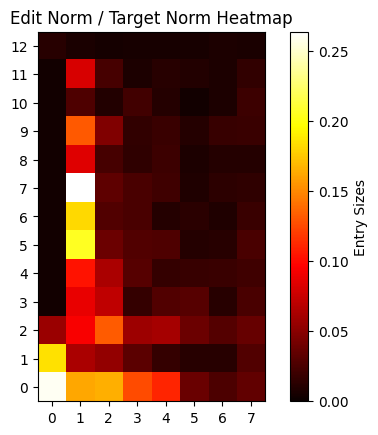

['The', ' story', ' is', ' based', ' in', ' two', ' time', ' periods']
['Sep', 'ul', 'ch', 're', ' is', ' a', ' novel', ' by', ' the', ' English', ' author', ' Kate', ' Mos', 'se', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


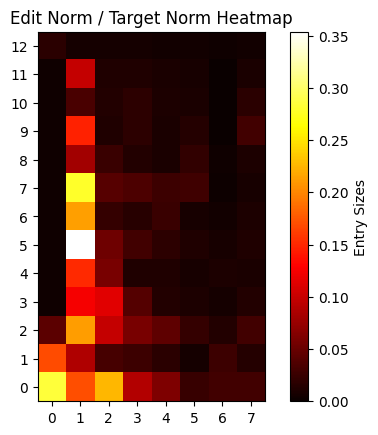

['It', ' was', ' released', ' in', ' 1981', ' as', ' part', ' of']
['"', 'St', 'arch', 'ild', '"', ' is', ' a', ' song', ' written', ' by', ' Wally', ' Bad', 'ar', 'ou', ',', ' Mark', ' King', ' and', ' Phil', ' Gould', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


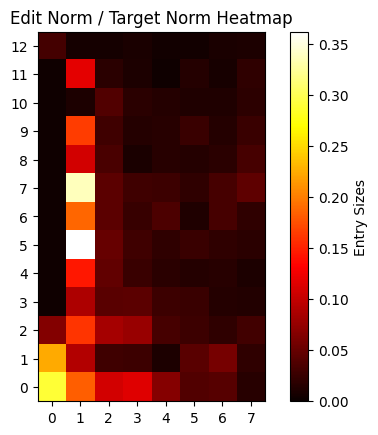

['She', ' was', ' built', ' in', ' 1929', ' as', ' Nancy', ' Baker']
['USS', ' Moon', 'stone', ' (', 'P', 'Y', 'c', '-', '9', ')', ' was', ' a', ' coastal', ' patrol', ' yacht', ' in', ' the', ' service', ' of', ' the', ' United', ' States', ' Navy', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


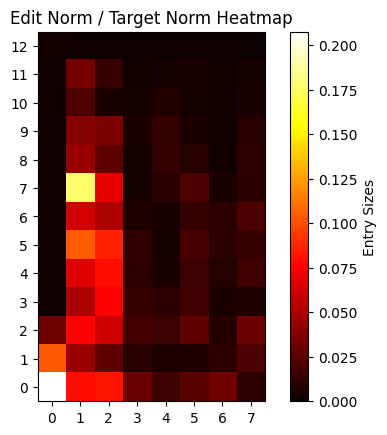

['Steven', 's', ' (', 'August', ' 11', ',', ' 18', '72']
['Ash', 'ton', ' P', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


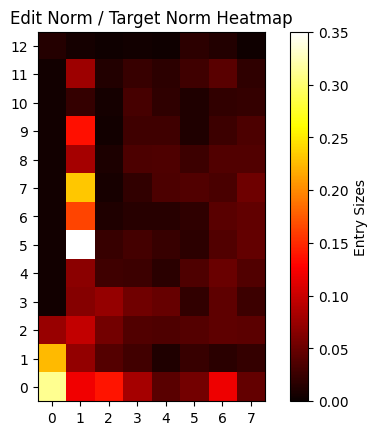

[' The', ' long', ',', ' skinny', ',', ' ', ' lake', ' lies']
['M', 'j', 'å', 'v', 'at', 'net', ' is', ' a', ' lake', ' that', ' lies', ' in', ' the', ' municipality', ' of', ' V', 'ef', 'sn', ' in', ' Nord', 'land', ' county', ',', ' Norway', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


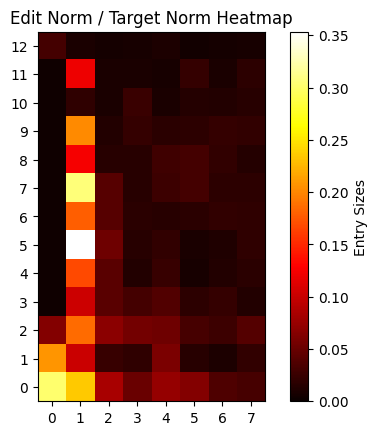

['He', ' is', ' a', ' former', ' Governor', ' of', ' the', ' Central']
['L', 'ak', 'sh', 'man', ' Ar', 'j', 'una', ' Ma', 'hend', 'ran', ' is', ' a', ' Sri', ' Lank', 'an', ' born', ',', ' Singapore', 'an', ' economist', ' and', ' banker', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


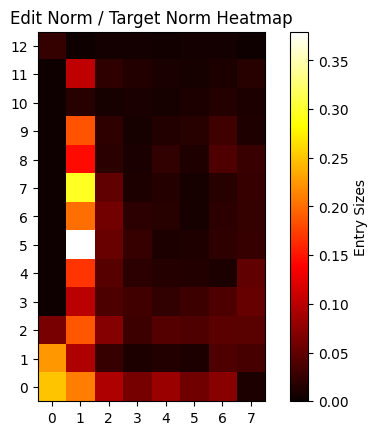

['He', ' is', ' an', ' Armenian', ' and', ' European', ' Champion', '.']
['Ar', 'man', ' Y', 'ere', 'my', 'an', ' (', ';', ' born', ' 29', ' January', ' 1986', ')', ' is', ' an', ' Armenian', ' ta', 'ek', 'w', 'ondo', ' athlete', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


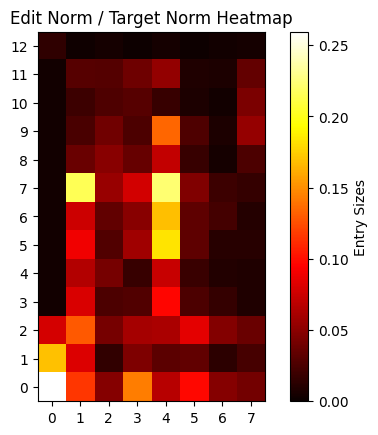

['By', ' September', ' 2010', ',', ' it', ' comprised', ' over', ' 850']
['Focus', '.', 'com', ' was', ' a', ' business', ' focused', ' social', ' networking', ' platform', ' and', ' source', ' of', ' technology', ' expertise', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


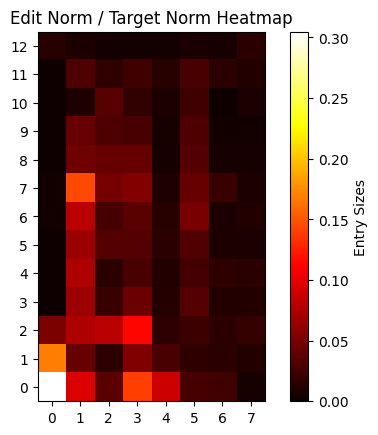

['(', 'October', ' 23', ',', ' 18', '01', 'October', ' 7']
['William', ' Henry', ' Hay', 'wood', ' Jr', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


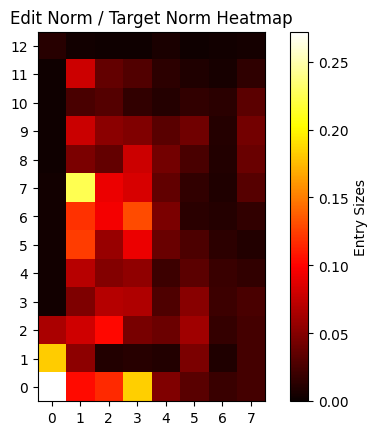

['A', ' terrestrial', ' species', ',', ' Z', '.', ' ter', 'rest']
['Z', 'y', 'gn', 'ema', ' is', ' a', ' genus', ' of', ' freshwater', ' filament', 'ous', ' th', 'all', 'oid', ' al', 'ga', ' comprising', ' about', ' 100', ' species', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


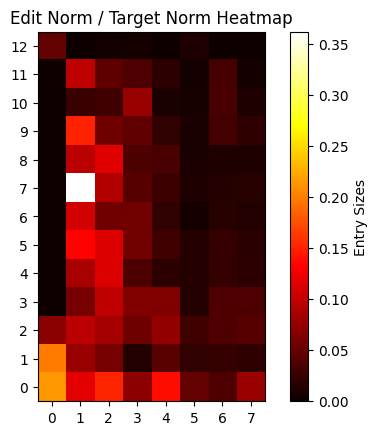

['Hist', 'orically', ',', ' most', ' were', ' nom', 'ads', ' living']
['The', ' Ab', 'ab', 'da', ' (', ' or', ' )', ' are', ' an', ' ethnic', ' group', ' from', ' eastern', ' Egypt', ' and', ' the', ' Sudan', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


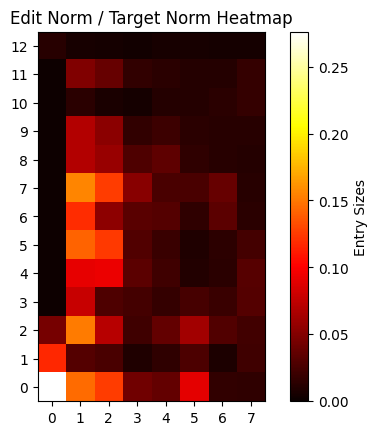

['64', ',', ' is', ' his', ' last', ' concert', 'o', '.']
['Fel', 'ix', ' Mend', 'els', 'so', 'hn', "'s", ' Viol', 'in', ' Conc', 'erto', ' in', ' E', ' minor', ',', ' Op', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


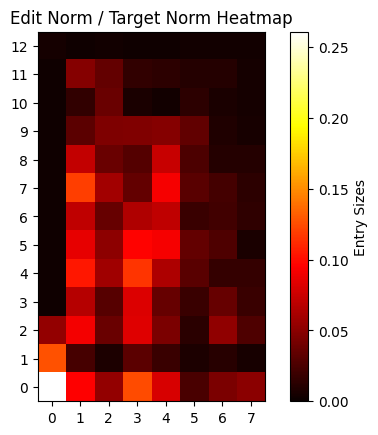

['16', '60', 's', ')', ' is', ' an', ' oil', ' on']
['A', ' Wood', 'ed', ' Marsh', ' (', 'c', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


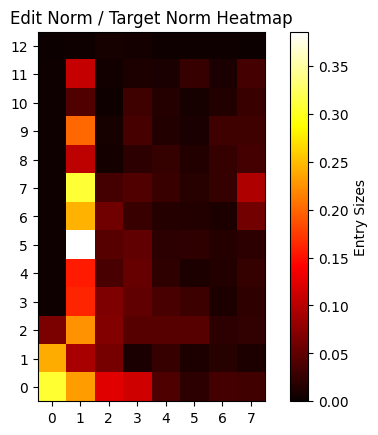

['It', ' is', ' part', ' of', ' the', ' T', 'ust', 'in']
['T', 'ust', 'in', ' High', ' School', ' is', ' a', ' public', ' high', ' school', ' in', ' T', 'ust', 'in', ',', ' California', ',', ' United', ' States', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


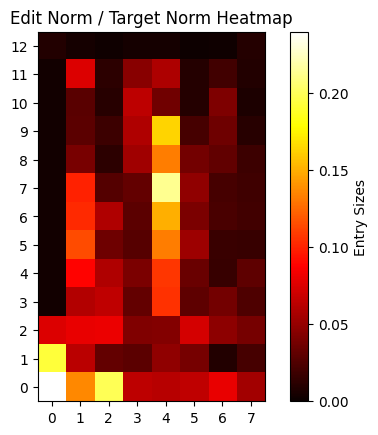

['Between', ' 1998', ' and', ' 2002', ' she', ' competed', ' for', ' Turkey']
['T', 'at', 'y', 'ana', ' Pol', 'nova', ' (),', ' n', 'ée', ' Z', 'ay', 'k', 'ova', ' (', ',', ' born', ' 20', ' April', ' 1979', ')', ' is', ' a', ' Russian', ' pole', ' v', 'aul', 'ter', '.']


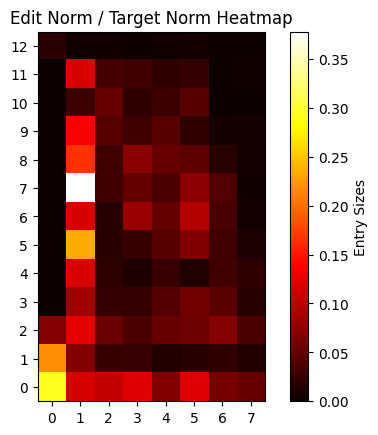

['Though', ' now', ' disappeared', ',', ' the', ' site', ' is', ' thought']
['H', 'ier', 'on', ' O', 'ros', ' was', ' a', ' town', ' of', ' ancient', ' Pont', 'us', ' on', ' the', ' Black', ' Sea', ' coast', ' of', ' As', 'i', 'atic', ' Turkey', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


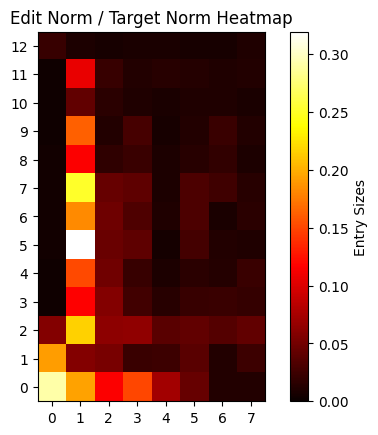

[' It', ' was', ' established', ' in', ' 18', '69', ' around', ' a']
['Bay', ' Furn', 'ace', ' was', ' a', ' town', ' in', ' Alger', ' County', ',', ' Michigan', ' west', ' of', ' Mun', 'ising', ',', ' Michigan', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


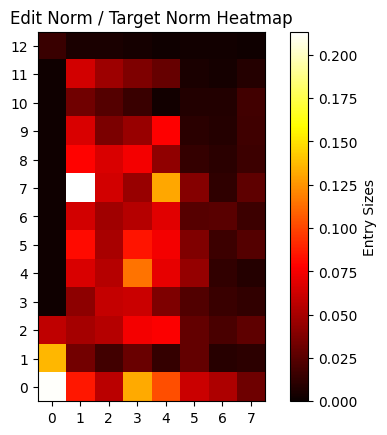

['E', 'mpire', ' Party', ')', ' was', ' a', ' political', ' party']
['The', ' Te', 'ik', 'ok', 'ut', 'ō', ' (', ',', ' lit', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


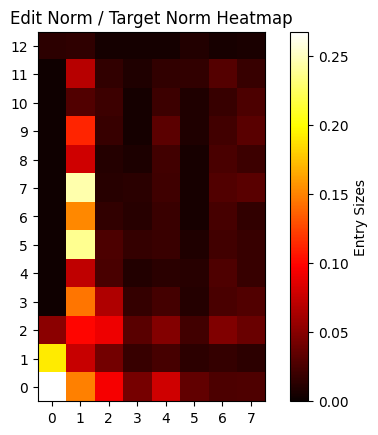

['It', ' delivers', ' a', ' mixture', ' of', ' nit', 'rous', ' oxide']
['A', ' relative', ' analges', 'ia', ' machine', ' is', ' used', ' by', ' dent', 'ists', ' to', ' induce', ' inhal', 'ation', ' sed', 'ation', ' in', ' their', ' patients', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


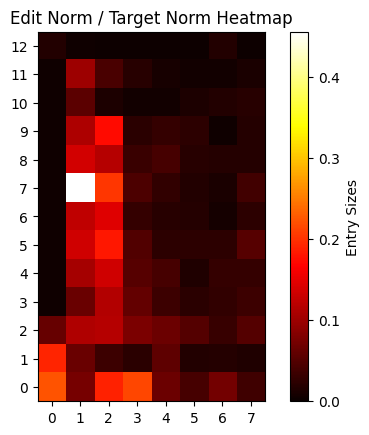

['Brown', 'ell', ' played', ' in', ' the', ' National', ' Basketball', ' League']
['William', ' Brown', 'ell', ' was', ' an', ' American', ' professional', ' basketball', ' player', ' and', ' coach', '.', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']


In [86]:
#This block calculates edit norm relative to the size of the current activations
import matplotlib.pyplot as plt
import numpy as np
for batch_index in range(min(20,len(batch["tokenized_next_50_tokens"]))):

    #The tensor norm comes in an 8x13 matrix
    edit_tensor = result["edit_vectors"][batch_index].to("cpu")
    edit_tensor[:8,:, :] = edit_tensor[:8,:,:]/result["target_hidden_states"][batch_index].norm(dim=2, keepdim=True) .to("cpu")
    edit_tensor_norm = edit_tensor.norm(dim=2).flip(1)

    # is this any better??
    # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

    # Detach and convert to numpy
    edit_tensor_norm = edit_tensor_norm.detach().numpy()[0:stopping_index, :]

    # Create the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(edit_tensor_norm.transpose(), cmap="hot")

    # Color the heatmap according to the entry sizes
    heatmap.set_clim(vmin=np.min(0), vmax=np.max(edit_tensor_norm))
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Entry Sizes")

    # Add labels to the x and y axes
    ax.set_yticks(np.arange(13))
    ax.set_xticks(np.arange(8))
    #ax.set_yticklabels(np.arange(13))
    ax.set_yticklabels(np.arange(12,-1,-1))
    ax.set_xticklabels(np.arange(8))

    # Rotate the x-axis labels
    #plt.xticks(rotation=90)

    # Add a title
    plt.title("Edit Norm / Target Norm Heatmap")

    # Show the plot
    plt.show()

    print(tokenizer.batch_decode(batch["tokenized_next_50_tokens"][batch_index][0:8]))
    print(tokenizer.batch_decode(batch["tokenized_first_sentence"][batch_index]))

In [ ]:
##### IGNORE BELOW! Old code!

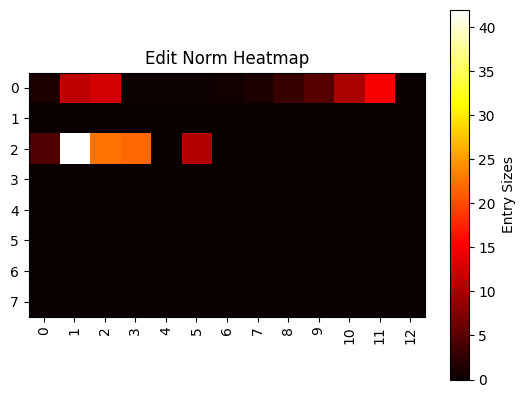

['In', ' the', ' bicycle', ',', ' she', ' hum', 'med', ' along']


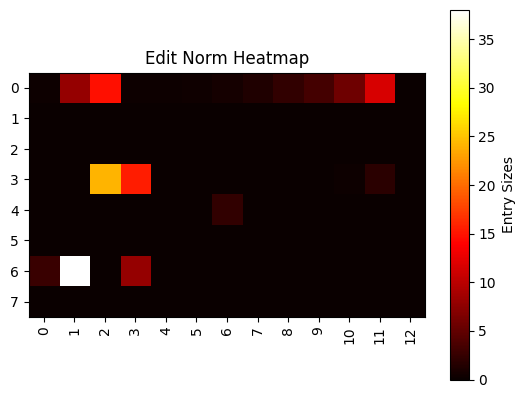

['In', ' the', ' cozy', ' library', ',', ' a', ' bird', ' lover']


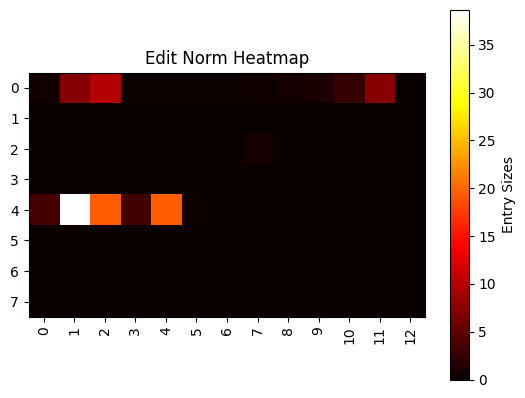

['B', 'ene', 'ath', ' the', ' cat', 'lit', ' sky', ',']


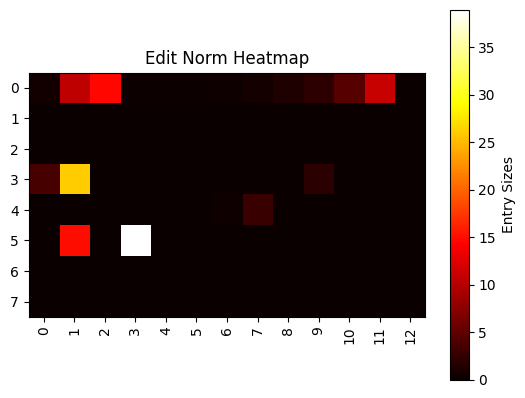

['Under', ' the', ' tall', ' ocean', ',', ' birds', ' sang', ' joy']


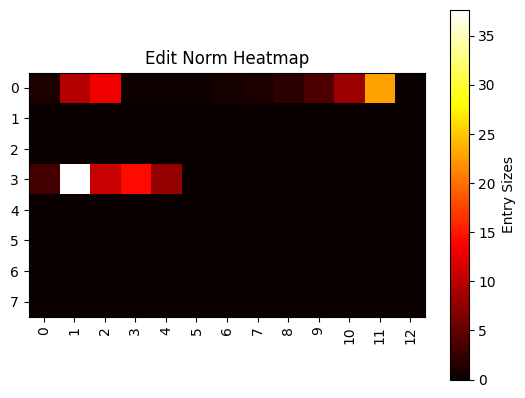

['A', ' slice', ' of', ' computer', ' can', ' bright', 'en', ' any']


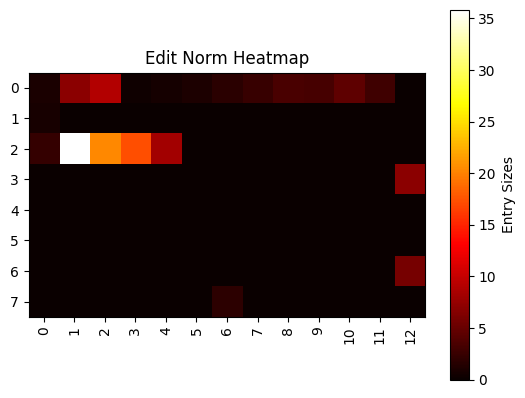

['A', ' loyal', ' chair', ' always', ' waits', ' by', ' the', ' door']


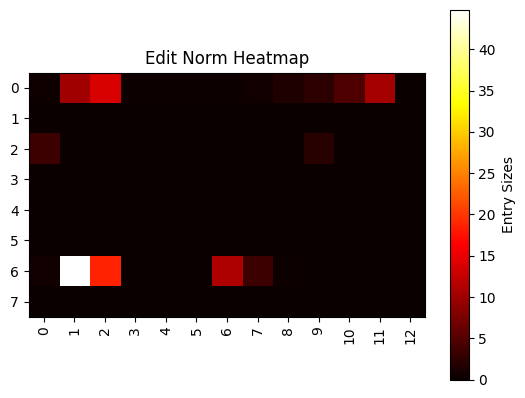

['On', ' the', ' ocean', ' rack', ' by', ' the', ' door', '.']


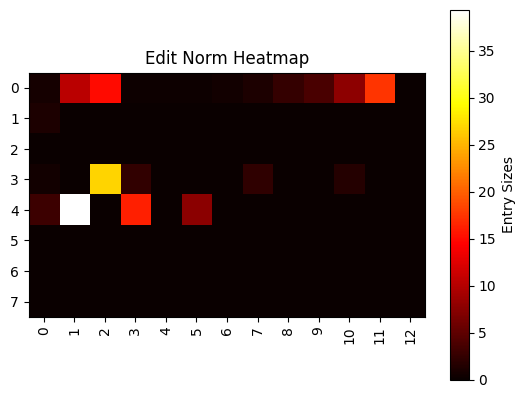

['Under', ' the', ' old', ' oak', ' star', ',', ' we', ' gathered']


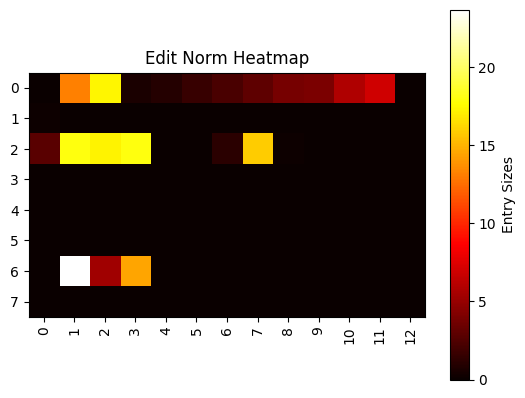

['A', ' delicious', ' flower', ' awaited', ' her', ' at', ' home', '.']


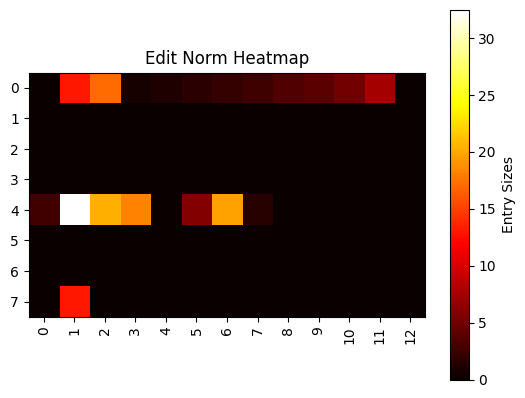

['In', ' a', ' shiny', ' red', ' flower', ',', ' we', ' raced']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for batch_index in range(min(10,len(batch["tokenized_next_50_tokens"]))):

    #The tensor norm comes in an 8x13 matrix
    edit_tensor = result["edit_vectors"][batch_index].to("cpu")
    edit_tensor_norm = edit_tensor.norm(dim=2)

    # is this any better??
    # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

    # Detach and convert to numpy
    edit_tensor_norm = edit_tensor_norm.detach().numpy()[0:stopping_index, :]

    # Create the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(edit_tensor_norm, cmap="hot")

    # Color the heatmap according to the entry sizes
    heatmap.set_clim(vmin=np.min(0), vmax=np.max(edit_tensor_norm))
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Entry Sizes")

    # Add labels to the x and y axes
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(13))
    ax.set_yticklabels(np.arange(8))

    # Rotate the x-axis labels
    plt.xticks(rotation=90)

    # Add a title
    plt.title("Edit Norm Heatmap")

    # Show the plot
    plt.show()

    print(tokenizer.batch_decode(batch["tokenized_next_50_tokens"][batch_index][0:8]))

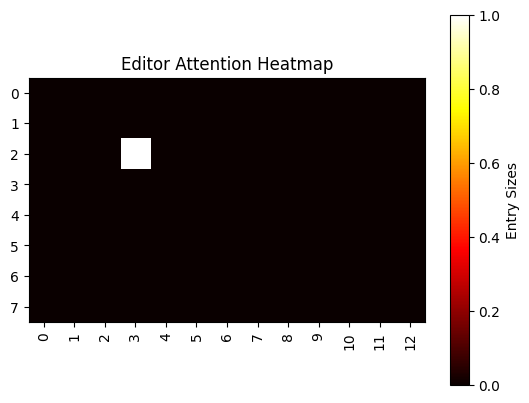

['In', ' the', ' bicycle', ',', ' she', ' hum', 'med', ' along', ',', ' and', ' then', ' she', ' turned', ' to', ' the', ' driver', '.', '\n', '\n', '"', 'I', "'m", ' not']


KeyError: 'editor_tokens'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
stopping_index = 8

for head_index in range(min(hypernetwork.editor_model.config.num_editing_heads,10)):
    for batch_index in range(3):

        # Reshape the tensor into an 8x13 matrix
        attention_matrix = result["editor_attention"][batch_index][head_index].reshape(8, 13).to("cpu")

        # is this any better??
        # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

        # Detach and convert to numpy
        attention_matrix = attention_matrix.detach().numpy()

        # Create the heatmap
        fig, ax = plt.subplots()
        heatmap = ax.imshow(attention_matrix, cmap="hot")

        # Color the heatmap according to the entry sizes
        heatmap.set_clim(vmin=np.min(attention_matrix), vmax=np.max(attention_matrix))
        cbar = plt.colorbar(heatmap)
        cbar.set_label("Entry Sizes")

        # Add labels to the x and y axes
        ax.set_xticks(np.arange(13))
        ax.set_yticks(np.arange(8))
        ax.set_xticklabels(np.arange(13))
        ax.set_yticklabels(np.arange(8))

        # Rotate the x-axis labels
        plt.xticks(rotation=90)

        # Add a title
        plt.title("Editor Attention Heatmap")

        # Show the plot
        plt.show()


        print(tokenizer.batch_decode(batch["result_text"][batch_index]))
        print(tokenizer.batch_decode(batch["editor_tokens"][batch_index][8:]))

In [ ]:
# torch.norm(
#     result["edit_vectors"][batch_index][:stopping_index, :, :].to("cpu"), dim=[0, 2]
# )  # looks better now!

Notes: It seems, currently, like we are not giving sufficient incentive to intervene at the lowest possible layer

In [ ]:
result["edit_vectors"].shape

torch.Size([160, 23, 13, 768])

In [ ]:
edit_tensor = result["edit_vectors"][batch_index].reshape(8, 13, -1).to("cpu")
edit_tensor_norm = edit_tensor.norm(dim=2)
edit_tensor_norm.shape

torch.Size([8, 13])

In [ ]:
edited_states = torch.stack(result['edited_hidden_states'],dim = 2)
edited_states.shape

torch.Size([160, 23, 13, 768])

In [ ]:
for i in range(8):
    print(edited_states[0][i][0].norm())

tensor(10.1000, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.7675, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.8729, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10.8826, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.3322, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.1028, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.0002, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.3511, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
print(
    torch.norm(result['target_hidden_states'][0][6][0]),
    torch.norm(result['target_hidden_states'][0][0][0]),
    edited_states[0][6][0].norm(),
    edited_states[0][2][0].norm()
)

tensor(5.0002, device='cuda:0') tensor(10.1001, device='cuda:0') tensor(5.0002, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(5.8729, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
# torch.save(hypernetwork.state_dict(), "/root/aiplay-1/hypernetworks/hypernetwork.pth")